In [10]:
# load vine dataset from scikit-learn
import torch 
from matplotlib import pyplot as plt
from sklearn.datasets import load_wine
torch.manual_seed(1234)

# load dataset
data = load_wine()
import pandas as pd
df=pd.DataFrame(data["data"],columns=data["feature_names"])
y=df["alcohol"]
x=df.drop("alcohol",axis=1)

In [11]:
# scale data

from sklearn.preprocessing import StandardScaler

scaler=StandardScaler()
scaler.fit(x)
x_scaled=scaler.transform(x)

x=pd.DataFrame(x_scaled,columns=x.columns)
x.head()

,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,-0.562250,0.232053,-1.169593,1.913905,0.808997,1.034819,-0.659563,1.224884,0.251717,0.362177,1.847920,1.013009
1,-0.499413,-0.827996,-2.490847,0.018145,0.568648,0.733629,-0.820719,-0.544721,-0.293321,0.406051,1.113449,0.965242
2,0.021231,1.109334,-0.268738,0.088358,0.808997,1.215533,-0.498407,2.135968,0.269020,0.318304,0.788587,1.395148
3,-0.346811,0.487926,-0.809251,0.930918,2.491446,1.466525,-0.981875,1.032155,1.186068,-0.427544,1.184071,2.334574
4,0.227694,1.840403,0.451946,1.281985,0.808997,0.663351,0.226796,0.401404,-0.319276,0.362177,0.449601,-0.037874


In [12]:

from sklearn.model_selection import train_test_split

x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=1234)


In [13]:


def root_mean_squared_error(y_hat,y):
    return torch.sqrt(torch.mean((y_hat-y)**2))



In [14]:
class WineDataset(torch.utils.data.Dataset):
    def __init__(self,x,y):                 # Konstruktor
        self.x=torch.tensor(x.values,dtype=torch.float32)   # x-Werte
        self.y=torch.tensor(y.values,dtype=torch.float32)


    def __getitem__(self,i):                # kann mit eckigen Klammern aufgerufen werden, z.B. [5] und gibt dann den 5. Eintrag zurück 
        return self.x[i],self.y[i]          # gibt x[i] und y[i] zurück
    

    def __len__(self):                      # die Länge des Datasets
        return len(self.x)

train_dataset=WineDataset(x_train,y_train)

x_sample, y_sample=train_dataset[0]   # train_dataset[0] ruft __getitem__ auf. Das liefert x[0] und y[0]. Die werden jeweils in x_sample und y_sample gespeichert

print(x_sample,y_sample)


tensor([-0.5982, -0.4259, -0.9294,  1.2820,  0.4885,  0.8742, -1.2236,  0.0510,
         0.3426, -0.1643,  0.8310,  0.9971]) tensor(13.7400)


In [15]:
class MyModel(torch.nn.Module):    # erbt von torch.nn.Module
    def __init__(self):             # Konstruktor
        super(MyModel, self).__init__()   # Aufruf des Super-Konstruktors
        self.fc1 = torch.nn.Linear(12, 10)    # Fully-Connected-Layer mit 12 Eingangsneuronen und 10 Ausgangsneuronen
        self.fc2 = torch.nn.Linear(10, 1)     # Fully-Connected-Layer mit 10 Eingangsneuronen und 1 Ausgangsneuronen
        self.batch_norm = torch.nn.BatchNorm1d(10)  # Batch-Normalization-Layer mit 10 Neuronen
        self.relu=torch.nn.ReLU()   # ReLU-Aktivierungsfunktion

    def forward(self, xb):          # wenn man das Modell aufruft mit (), wird diese Methode ausgeführt
        xb = self.relu(self.fc1(xb))   # a2
        xb = self.batch_norm(xb)  # a2_norm=a2-mean/std
        xb = self.fc2(xb)
        return xb

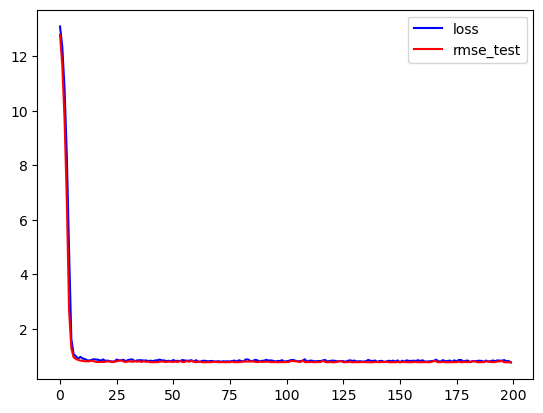

In [16]:
lr=0.01
wd=0.00001
batch_size=10
torch.manual_seed(1234)

epochs=200
losses=[]
rmse_test=[]
hidden_count=20

model=MyModel()

train_dataset=WineDataset(x_train,y_train)

train_loader=torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

#optimizer=torch.optim.SGD(model.parameters(), lr=lr, weight_decay=wd)
optimizer=torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)

y_train_tensor=torch.tensor(y_train.values, dtype=torch.float32)
x_test_tensor=torch.tensor(x_test.values, dtype=torch.float32)
y_test_tensor=torch.tensor(y_test.values, dtype=torch.float32)
for i in range(epochs):
    losses_in_epoch=[]
    # trainiere jeweils mit einer kleinen Auswahl an Daten, der Batch
    # xb: ist die Auswahl der Daten für die Inputneuronen
    # yb: ist die Auswahl der Daten für die Outputneuronen
    for xb,yb in train_loader:
        y_hat=model(xb)   # Forward Propagation
        loss=root_mean_squared_error(y_hat, yb)
        losses_in_epoch.append(loss.item())
        loss.backward()
        optimizer.step()    # Update der Gewichte
        optimizer.zero_grad()       # Zurücksetzen des Gradienten
        
    losses.append(sum(losses_in_epoch)/len(losses_in_epoch))
    y_test_hat=model(x_test_tensor)
    y_test_rmse=root_mean_squared_error(y_test_hat, y_test_tensor)
    rmse_test.append(y_test_rmse.item())

plt.plot(range(epochs),losses, color="blue")
plt.plot(range(epochs),rmse_test, color="red")
plt.legend(["loss", "rmse_test"])
plt.show()


In [17]:
y_test_hat=model(x_test_tensor)
rmse_test=root_mean_squared_error(y_test_hat, y_test_tensor)
rmse_test.item()

0.7711009979248047